In [90]:
# ---------- 1. Imports ----------
import os, json, re, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from typing import Union, List, Dict, Any
from utils import load_records, assign_problem_type, classify_error_better, analyze
import importlib
import utils
importlib.reload(utils)


<module 'utils' from '/Users/shanrulin/Desktop/ncg/LiveCodeBench/output/error_analysis/utils.py'>

In [ ]:
# ---------- 5. Visualization ----------
def plot_distribution(df_counts, label_col, title, save_path):
    if df_counts.empty:
        print(f"[Skip] No data for {title}")
        return

    # --- 固定难度排序 ---
    if label_col.lower() == "difficulty":
        order = ["Easy", "Medium", "Hard"]
        df_counts["order"] = df_counts[label_col].apply(lambda x: order.index(x) if x in order else 999)
        df_counts = df_counts.sort_values("order").drop(columns=["order"])

    # --- 打印数值表 ---
    print(f"\n==== {title} ====")
    print(df_counts.head(20).to_string(index=False))

    # --- 图表尺寸：略收紧 ---
    num_items = len(df_counts.head(20))
    height = min(max(3, 0.35 * num_items), 6)   # 限制高度在 3～6 英寸之间
    plt.figure(figsize=(8, height))

    # --- 绘制横向条形图 ---
    plt.barh(df_counts[label_col], df_counts["count"],
             color="cornflowerblue", edgecolor="black", alpha=0.85, height=0.6)

    plt.gca().invert_yaxis()
    plt.xlabel("Count", fontsize=12)
    plt.ylabel(label_col, fontsize=12)
    plt.title(title, fontsize=14, weight="bold", pad=8)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.tight_layout()

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=150)
    plt.show()



# ---------- 6. Cross Analysis ----------
import seaborn as sns
import matplotlib.pyplot as plt

def cross_analysis(df):
    os.makedirs("results", exist_ok=True)

    def _plot_heatmap(data, title, save_path):
        plt.figure(figsize=(max(8, 1.2 * len(data.columns)), max(5, 0.6 * len(data))))
        sns.heatmap(data, annot=True, fmt="d", cmap="Blues")
        plt.xticks(rotation=40, ha="right")  # 列名斜着显示
        plt.yticks(rotation=0)
        plt.title(title, fontsize=13, weight="bold")
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
        plt.show()


    # ---- ProblemType × ErrorType ----
    if "ProblemType" in df.columns and "ErrorType" in df.columns:
        cross_pe = pd.crosstab(df["ProblemType"], df["ErrorType"])
        print("\n==== Cross: ProblemType × ErrorType ====")
        print(cross_pe)
        cross_pe.to_csv("results/cross_problem_error.csv")
        _plot_heatmap(cross_pe, "ProblemType × ErrorType", "results/cross_problem_error.png")

    # ---- ProblemType × Difficulty ----
    if "difficulty" in df.columns:
        cross_diff = pd.crosstab(df["ProblemType"], df["difficulty"])
        print("\n==== Cross: ProblemType × Difficulty ====")
        print(cross_diff)
        cross_diff.to_csv("results/cross_problem_difficulty.csv")
        _plot_heatmap(cross_diff, "ProblemType × Difficulty", "results/cross_problem_difficulty.png")

    # ---- ProblemType × Platform ----
    if "platform" in df.columns:
        cross_plat = pd.crosstab(df["ProblemType"], df["platform"])
        print("\n==== Cross: ProblemType × Platform ====")
        print(cross_plat)
        cross_plat.to_csv("results/cross_problem_platform.csv")
        _plot_heatmap(cross_plat, "ProblemType × Platform", "results/cross_problem_platform.png")



In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_pass_fail_distribution(df, feature, save_dir="results"):
    """
    绘制横向 Pass vs Fail 堆叠柱状图 (更适合展示与比较)
    """
    os.makedirs(save_dir, exist_ok=True)

    # ---- 基础统计 ----
    df["Status"] = df["pass@1"].apply(lambda x: "Pass" if x == 1 else "Fail")
    stats = (
        df.groupby([feature, "Status"])
          .size()
          .reset_index(name="count")
          .pivot(index=feature, columns="Status", values="count")
          .fillna(0)
    )

    stats["Total"] = stats["Pass"] + stats["Fail"]
    stats["PassRate"] = stats["Pass"] / stats["Total"] * 100

    # ---- 排序 (按总数或通过率) ----
    stats = stats.sort_values("Total", ascending=True)

    # ---- 绘图 ----
    plt.figure(figsize=(10, max(5, len(stats) * 0.4)))

    # 颜色柔和风格
    pass_color = "#8DD3C7"   # 柔和青绿
    fail_color = "#FB8072"   # 柔和珊瑚红

    plt.barh(stats.index, stats["Fail"], color=fail_color, label="Fail")
    plt.barh(stats.index, stats["Pass"], left=stats["Fail"], color=pass_color, label="Pass")

    # ---- 标注 Pass Rate ----
    for i, (fail, total, rate) in enumerate(zip(stats["Fail"], stats["Total"], stats["PassRate"])):
        plt.text(total + max(stats["Total"]) * 0.01, i, f"{rate:.1f}%", 
                 va="center", ha="left", fontsize=9, color="#333333")

    # ---- 样式 ----
    plt.title(f"Pass vs Fail Distribution by {feature.title()}", fontsize=14, weight="bold", pad=10)
    plt.xlabel("Number of Cases")
    plt.ylabel(feature.title())
    plt.grid(axis="x", linestyle="--", alpha=0.4)
    plt.legend(loc="lower right", frameon=False, fontsize=9)
    plt.tight_layout()

    save_path = os.path.join(save_dir, f"{feature}_pass_fail_hbar.png")
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"✅ Saved: {save_path}")


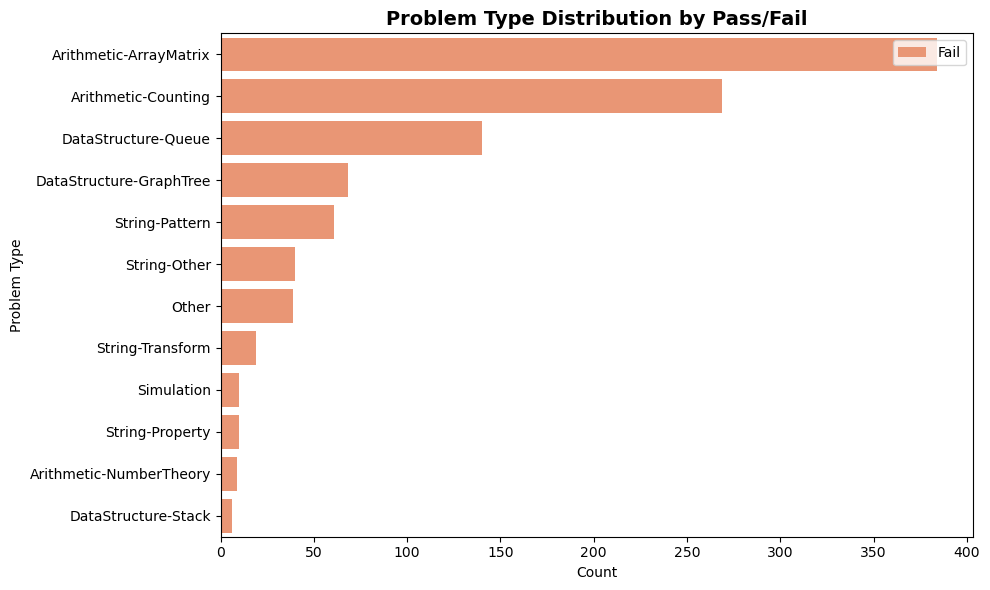


==== Problem Type Distribution ====
            ProblemType  count
 Arithmetic-ArrayMatrix    384
    Arithmetic-Counting    269
    DataStructure-Queue    140
DataStructure-GraphTree     68
         String-Pattern     61
           String-Other     40
                  Other     39
       String-Transform     19
        String-Property     10
             Simulation     10
Arithmetic-NumberTheory      9
    DataStructure-Stack      6


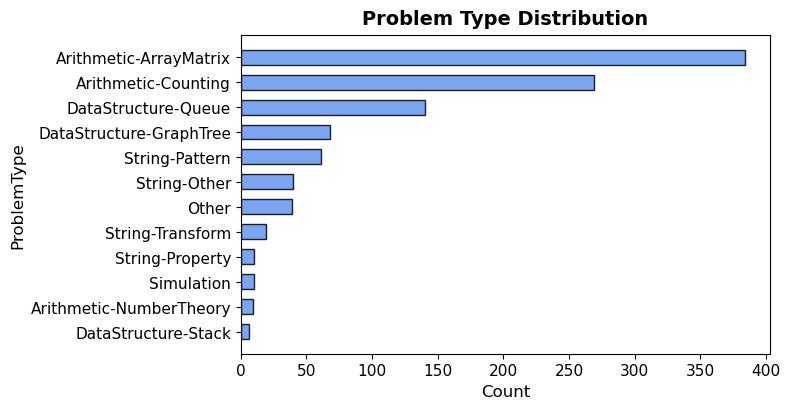


==== Error Type Distribution ====
                  ErrorType  count
                       Pass    293
WrongAnswer-NumericMismatch    210
WrongAnswer (no diff shown)    177
     TestingError-Indention     97
     TestingError-Unpacking     96
               RuntimeError     95
WrongAnswer-BooleanMismatch     43
                    Timeout     23
 WrongAnswer-SymbolMismatch     17
         TestingError-Other      1
         TestingError-Index      1
     TestingError-Generator      1
        TestingError-Syntax      1


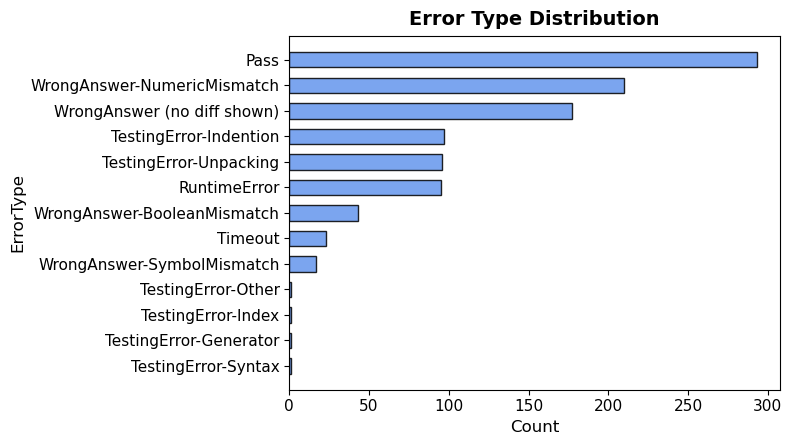


==== Difficulty Distribution ====
difficulty  count
      easy    322
      hard    350
    medium    383


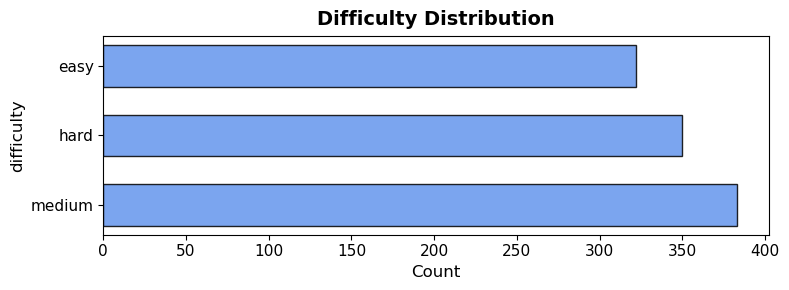


==== Platform Distribution ====
  platform  count
   atcoder    602
codeforces      9
  leetcode    444


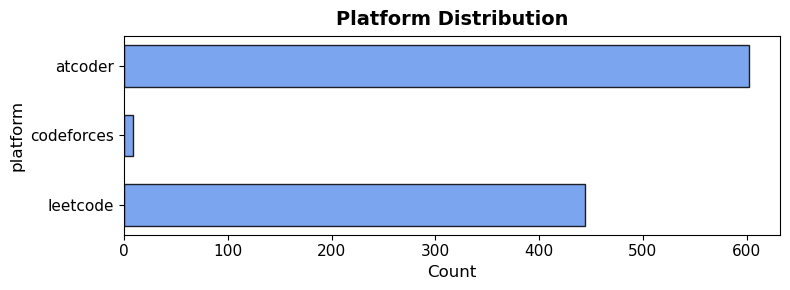


==== Cross: ProblemType × ErrorType ====
ErrorType                Pass  RuntimeError  TestingError-Generator  \
ProblemType                                                           
Arithmetic-ArrayMatrix    118            23                       0   
Arithmetic-Counting        75            13                       0   
Arithmetic-NumberTheory     1             2                       0   
DataStructure-GraphTree     5            15                       1   
DataStructure-Queue        24            24                       0   
DataStructure-Stack         2             1                       0   
Other                      18             3                       0   
Simulation                  2             1                       0   
String-Other               17             1                       0   
String-Pattern             21             7                       0   
String-Property             2             4                       0   
String-Transform            8      

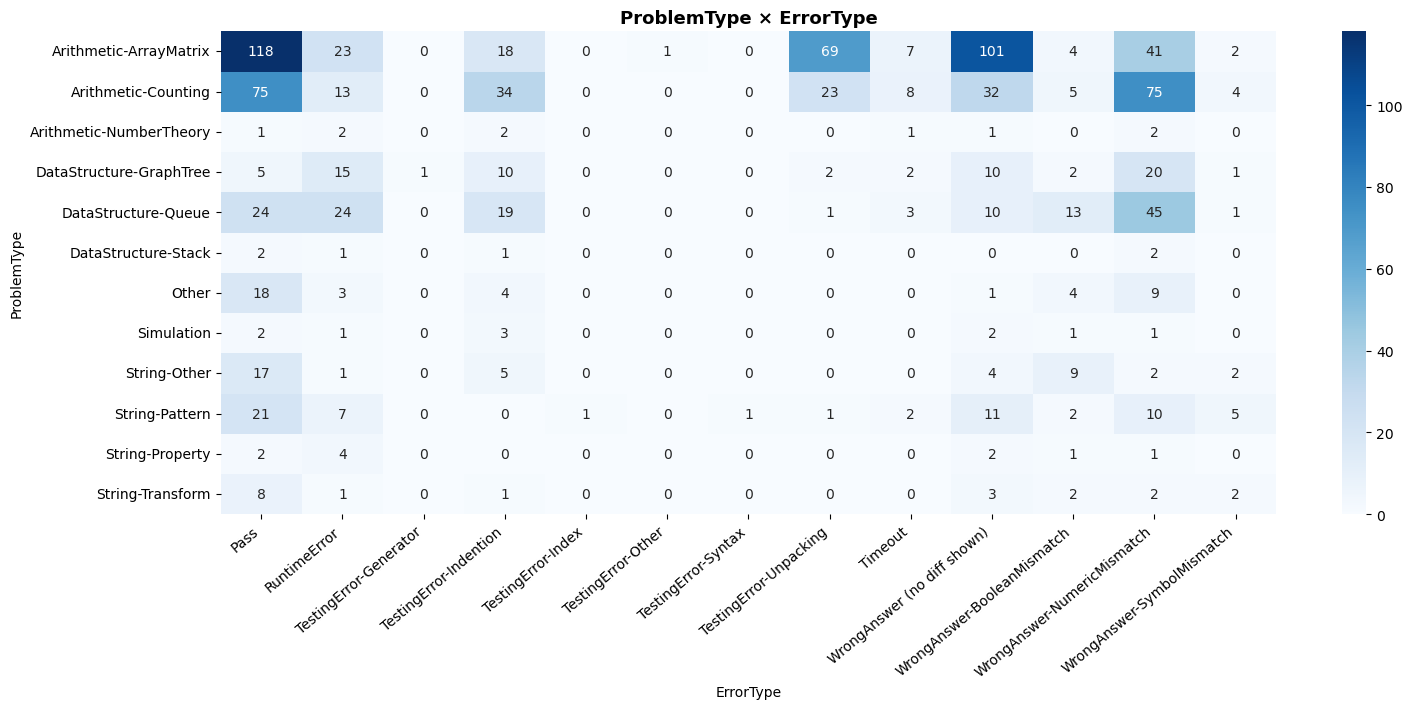


==== Cross: ProblemType × Difficulty ====
difficulty               easy  hard  medium
ProblemType                                
Arithmetic-ArrayMatrix    100   125     159
Arithmetic-Counting        80    80     109
Arithmetic-NumberTheory     2     3       4
DataStructure-GraphTree     5    50      13
DataStructure-Queue        34    64      42
DataStructure-Stack         2     0       4
Other                      28     5       6
Simulation                  4     2       4
String-Other               26     5       9
String-Pattern             26    12      23
String-Property             6     1       3
String-Transform            9     3       7


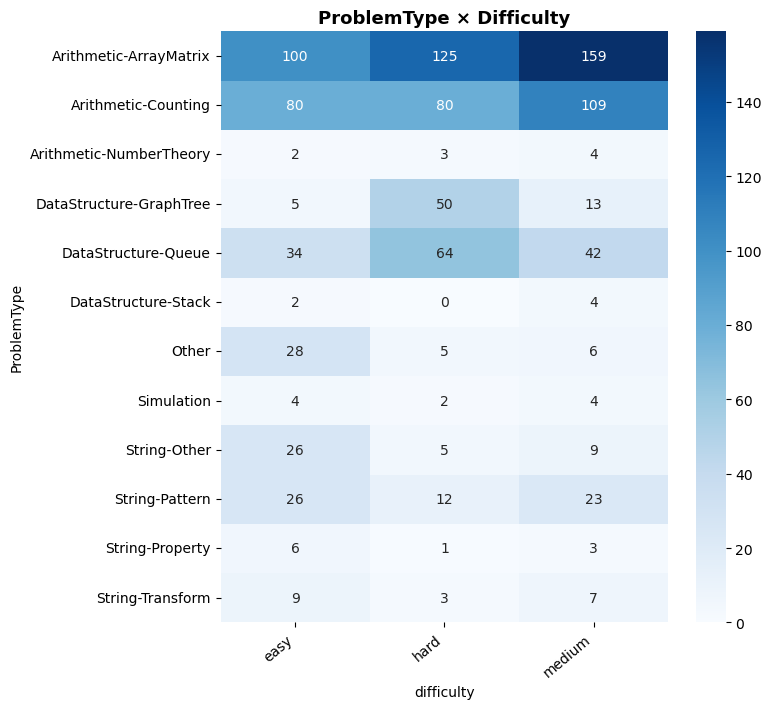


==== Cross: ProblemType × Platform ====
platform                 atcoder  codeforces  leetcode
ProblemType                                           
Arithmetic-ArrayMatrix        95           0       289
Arithmetic-Counting          181           0        88
Arithmetic-NumberTheory        8           0         1
DataStructure-GraphTree       53           0        15
DataStructure-Queue          119           9        12
DataStructure-Stack            6           0         0
Other                         36           0         3
Simulation                     9           0         1
String-Other                  35           0         5
String-Pattern                39           0        22
String-Property                7           0         3
String-Transform              14           0         5


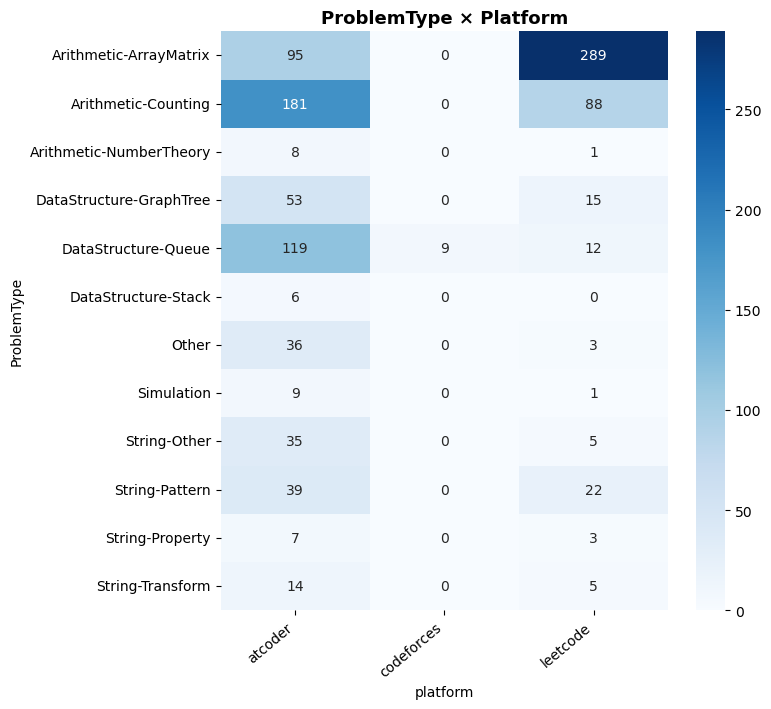


✅ All analyses done. Results saved in /results

==== All 'String' Problems ====
Empty DataFrame
Columns: [question_title, platform, difficulty]
Index: []

Total String Problems: 0


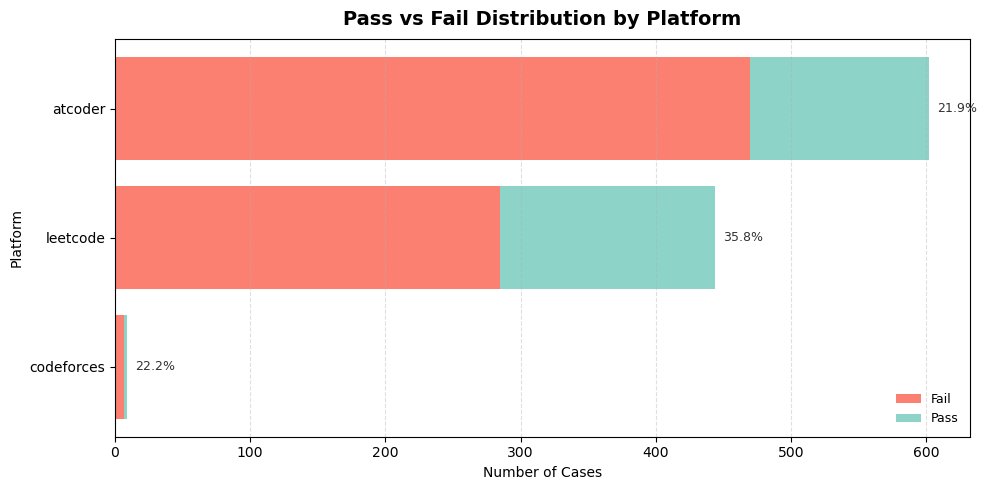

✅ Saved: results/platform_pass_fail_hbar.png


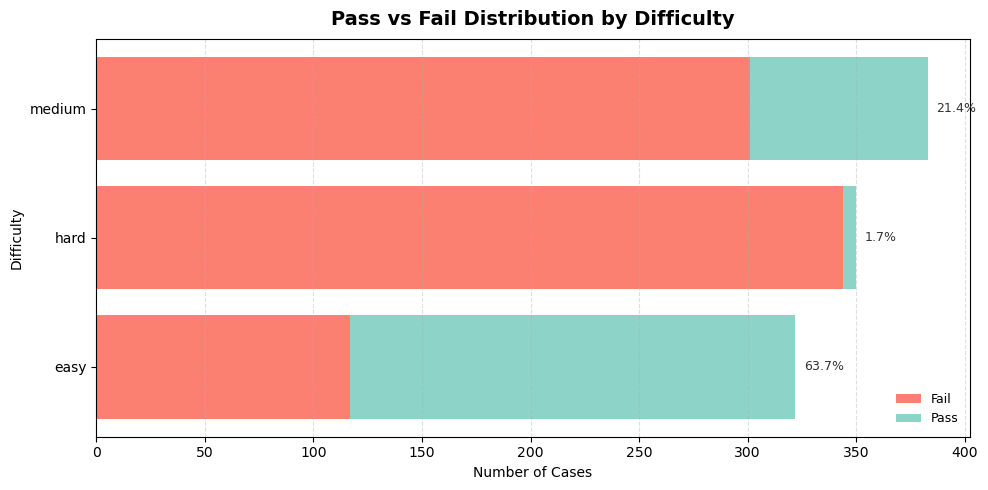

✅ Saved: results/difficulty_pass_fail_hbar.png


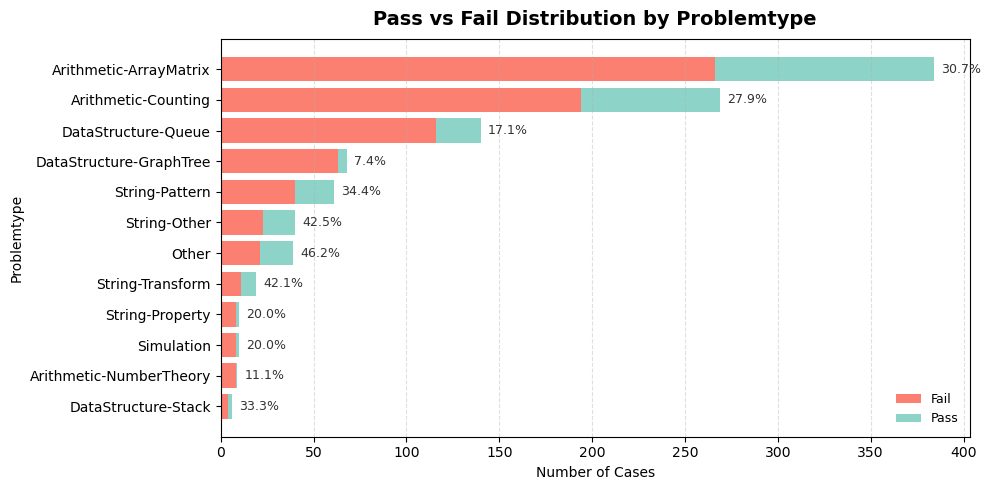

✅ Saved: results/ProblemType_pass_fail_hbar.png


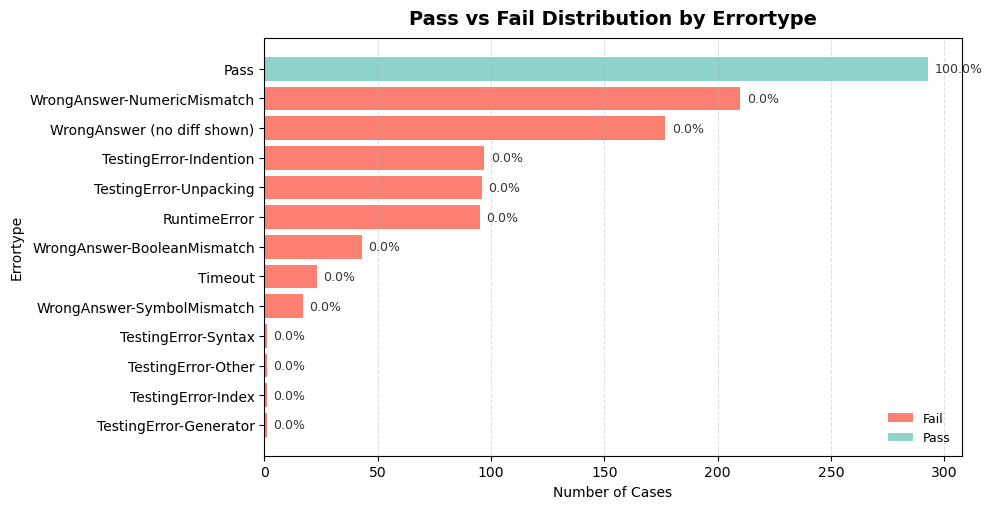

✅ Saved: results/ErrorType_pass_fail_hbar.png


In [98]:
# ---------- 7. Main ----------
def main():
    path = "/Users/shanrulin/Desktop/ncg/LiveCodeBench/output/Qwen2.5-Ins-7B/Scenario.selfrepair_1_0.2_eval_all.json"
    records = load_records(path)
    df, problem_counts, error_counts, diff_counts, plat_counts = analyze(records)

    if "pass@1" in df.columns:
        df["PassStatus"] = df["pass@1"].apply(lambda x: "Pass" if x == 1 else "Fail")
    elif "graded_list" in df.columns:
        df["PassStatus"] = df["graded_list"].apply(
            lambda g: "Pass" if isinstance(g, list) and any(x == "pass" for x in g) else "Fail"
        )
    elif "ErrorType" in df.columns:
        df["PassStatus"] = df["ErrorType"].apply(lambda x: "Pass" if x == "No Error Message" else "Fail")
    else:
        df["PassStatus"] = "Unknown"

    os.makedirs("results", exist_ok=True)
    problem_counts.to_csv("results/problemtype_counts.csv", index=False)
    error_counts.to_csv("results/errortype_counts.csv", index=False)
    if not diff_counts.empty:
        diff_counts.to_csv("results/difficulty_counts.csv", index=False)
    if not plat_counts.empty:
        plat_counts.to_csv("results/platform_counts.csv", index=False)
    df.to_json("results/processed.json", orient="records", indent=2)

        # ===== Pass/Fail breakdown for ProblemType =====
    df["PassStatus"] = df["ErrorType"].apply(lambda x: "Pass" if x == "No Error Message" else "Fail")

    counts_pf = df.groupby(["ProblemType", "PassStatus"]).size().reset_index(name="count")

    order = counts_pf.groupby("ProblemType")["count"].sum().sort_values(ascending=False).index

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=counts_pf,
        y="ProblemType", x="count", hue="PassStatus", order=order,
        palette={"Pass": "#66c2a5", "Fail": "#fc8d62"}
    )
    plt.title("Problem Type Distribution by Pass/Fail", fontsize=14, weight="bold")
    plt.xlabel("Count")
    plt.ylabel("Problem Type")
    plt.legend(title="", loc="upper right")
    plt.tight_layout()

    os.makedirs("results", exist_ok=True)
    plt.savefig("results/problemtype_pass_fail.png", dpi=300)
    plt.show()


    plot_distribution(problem_counts, "ProblemType", "Problem Type Distribution", "results/problemtype_dist.png")
    plot_distribution(error_counts, "ErrorType", "Error Type Distribution", "results/errortype_dist.png")
    if not diff_counts.empty:
        plot_distribution(diff_counts, "difficulty", "Difficulty Distribution", "results/difficulty_dist.png")
    if not plat_counts.empty:
        plot_distribution(plat_counts, "platform", "Platform Distribution", "results/platform_dist.png")

    cross_analysis(df)
    print("\n✅ All analyses done. Results saved in /results")

    print("\n==== All 'String' Problems ====")
    string_df = df[df["ProblemType"] == "String"]
    print(string_df[["question_title", "platform", "difficulty"]].to_string(index=False))
    print(f"\nTotal String Problems: {len(string_df)}")

    plot_pass_fail_distribution(df, "platform")
    plot_pass_fail_distribution(df, "difficulty")
    plot_pass_fail_distribution(df, "ProblemType")
    plot_pass_fail_distribution(df, "ErrorType")


if __name__ == "__main__":
    main()
